<a href="https://colab.research.google.com/github/EagleAtom1984/AI-Behaviour/blob/main/Class_project_Eye_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 3 - Data Augmentation and Transfer Learning

## Transfer learning - ResNet18 network

This time I'm making use of a commonly used network architecture, ResNet18, taken from here: https://pytorch.org/vision/0.8/models.html#classification

I need to update the final layer for the network as the pre-trained networks are trained on the ImageNet dataset which has 1000 classes and my dataset has just two classes. We can choose to either train the whole network starting from the pre-trained weights (fine tuning) or freeze the pre-trained weights and just update the weights for the new final layer.

I used this tutorial for guidance: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

NB This network requires an image input size of `3x224x224` and normalised using `mean = [0.485, 0.456, 0.406]` and `standard deviation = [0.229, 0.224, 0.225]`. So these values need updating both in the imshow function and when defining the transforms.

This network will benefit from using a GPU for training (otherwise it'll take ages). You can select a GPU runtime by going to 'Runtime/Change runtime type'. You also need to move the model, images (data), and labels (target) to the GPU with the `.cuda()` method. If you then want to display these images on the CPU (in the testing stage) you need to bring them back with the `.cpu()` method.

## Data augmentation
I'm adding some data augmentation (random flipping and rotating) to the training set. For this I need to create a new transform and use it when I load the training data.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import torch
from torchvision import datasets, transforms
import torchvision.transforms as transforms
from PIL import Image
import math
import pandas as pd

import time
from datetime import timedelta

import math
import os

import scipy.misc
from scipy.stats import itemfreq
from random import sample

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

import PIL.Image
from IPython.display import display

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available. Training on CPU.')
else:
  print('CUDA is available. Training on GPU.')

CUDA is available. Training on GPU.


In [2]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!unzip '/content/gdrive/MyDrive/Eye_Images_6.zip' > /dev/null

In [5]:
data_dir = 'Eye_Images_6'

batch_size = 80

train_transform = transforms.Compose([transforms.Resize(225), 
                                transforms.RandomRotation(12), 
                                transforms.CenterCrop(225), 
                                transforms.RandomHorizontalFlip(), 
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])]) 

transform = transforms.Compose([transforms.Resize(225),
                                transforms.CenterCrop(225),
                                transforms.ToTensor(), 
                                transforms.Normalize([0.485, 0.456, 0.406],
                                                     [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transform)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

train_loader_2 = torch.utils.data.DataLoader(test_data, batch_size, shuffle=False)

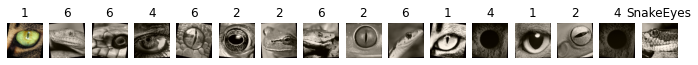

In [6]:
from matplotlib import figure
from torchvision.datasets.folder import is_image_file

data_iter = iter(train_loader)
images, labels = next(data_iter)

lables_map = {
    0: "AlligatorEyes",
    1: "CatEyes",
    2: "FrogEyes",
    3: "GoatEyes",
    4: "HumanEyes",
    5: "OwlEyes",
    6: "SnakeEyes",
    7: "WhaleEyes",
}

cols, rows = 3, 3
  
fig, axes = plt.subplots(figsize=(12,4), ncols=16)
for ii in range(16):
    ax = axes[ii]
    imshow(images[ii], ax=ax, normalize=True)
    ax.set_title(str(labels[ii].item())) 
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    plt.title(lables_map[label])
    transform = transforms.Grayscale()
    images = transform(images)
plt.show()

In [7]:
import torch.nn as nn
import torchvision.models as models

model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 512)


if train_on_gpu:
    model.cuda()

print(model)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
n_epochs = 18

valid_loss_min = np.Inf 

train_losses, val_losses = [], []

for epoch in range(n_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    
    model.train() 
    for data, target in train_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
      
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)
        
        loss.backward()
       
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    model.eval() 
    for data, target in val_loader:
        
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
       
        output = model(data)
        
        loss = criterion(output, target)
       
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(val_loader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'resnet18_model_fine_tune_aug.pt') 
        torch.save(model.state_dict(), '/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.468611 	Validation Loss: 0.651977
Validation loss decreased (inf --> 0.651977).  Saving model ...
Epoch: 2 	Training Loss: 0.224126 	Validation Loss: 1.436335
Epoch: 3 	Training Loss: 0.120173 	Validation Loss: 0.917678
Epoch: 4 	Training Loss: 0.071253 	Validation Loss: 0.476796
Validation loss decreased (0.651977 --> 0.476796).  Saving model ...
Epoch: 5 	Training Loss: 0.049255 	Validation Loss: 0.198295
Validation loss decreased (0.476796 --> 0.198295).  Saving model ...
Epoch: 6 	Training Loss: 0.028425 	Validation Loss: 0.522154
Epoch: 7 	Training Loss: 0.022631 	Validation Loss: 1.064552
Epoch: 8 	Training Loss: 0.011998 	Validation Loss: 0.693214
Epoch: 9 	Training Loss: 0.008602 	Validation Loss: 0.118001
Validation loss decreased (0.198295 --> 0.118001).  Saving model ...
Epoch: 10 	Training Loss: 0.004750 	Validation Loss: 0.055080
Validation loss decreased (0.118001 --> 0.055080).  Saving model ...
Epoch: 11 	Training Loss: 0.003494 	Validation Lo

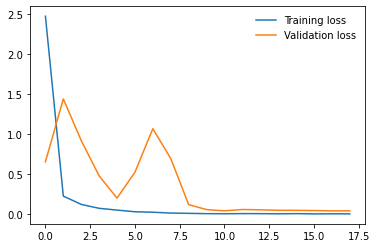

In [10]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)

In [11]:
model.load_state_dict(torch.load('resnet18_model_fine_tune_aug.pt'))

<All keys matched successfully>

In [12]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()

for data, target in test_loader:
    
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    
    loss = criterion(output, target)
    
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1)
    
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(8):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.021588

Test Accuracy of     0: 100% (40/40)
Test Accuracy of     1: 97% (74/76)
Test Accuracy of     2: 100% (34/34)
Test Accuracy of     3: 100% (24/24)
Test Accuracy of     4: 100% (88/88)
Test Accuracy of     5: 100% (26/26)
Test Accuracy of     6: 98% (95/96)
Test Accuracy of     7: 100% ( 8/ 8)

Test Accuracy (Overall): 99% (389/392)


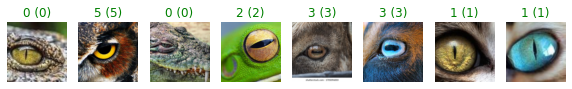

In [13]:
dataiter = iter(test_loader)
images, labels = next(dataiter)
images.numpy()

if train_on_gpu:
    images = images.cuda()

output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

fig, axes = plt.subplots(figsize=(10,4), ncols=8)
for ii in range(8):
    ax = axes[ii]
    imshow(images.cpu()[ii], ax=ax, normalize=True)
    ax.set_title("{} ({})".format(str(preds[ii].item()), str(labels[ii].item())),
                 color=("green" if preds[ii]==labels[ii] else "red")) 

In [14]:
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable

myModel = models.resnet18(pretrained=True)
myModel = nn.Sequential(*list(model.children())[:-1])

if train_on_gpu:
  myModel.cuda()

print(myModel)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
myTrainedModel = models.resnet18(pretrained=True)
number_ftrs = myTrainedModel.fc.in_features
myTrainedModel.fc = nn.Linear(number_ftrs, 512)
myTrainedModel.load_state_dict(torch.load('/content/gdrive/MyDrive/resnet18_model_fine_tune_aug.pt'))
myTrainedModel = nn.Sequential(*list(myTrainedModel.children())[:-1])

if train_on_gpu:
  myTrainedModel.cuda()

print(myTrainedModel)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [16]:
dataiter = iter(train_loader)
images, lables = next(dataiter)

if train_on_gpu:
  images = images.cuda()

imageNet_feats = model(images)
eye_feats = myTrainedModel(images)

imageNet_feats = np.squeeze(imageNet_feats.cpu().detach().numpy())
eye_feats = np.squeeze(eye_feats.cpu().detach().numpy())

labels = labels.numpy()

print(imageNet_feats.shape)
print(eye_feats.shape)
print(labels)

(80, 512)
(80, 512)
[0 5 0 2 3 3 1 1 4 4 5 3 0 6 4 6 0 0 4 6 4 1 5 6 0 5 1 4 6 0 2 1 1 4 4 4 1
 1 7 0 1 0 2 4 6 6 2 4 3 6 4 5 3 6 1 4 1 4 0 4 1 4 4 1 6 6 3 0 2 4 0 6 1 2
 6 1 0 5 2 5]


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


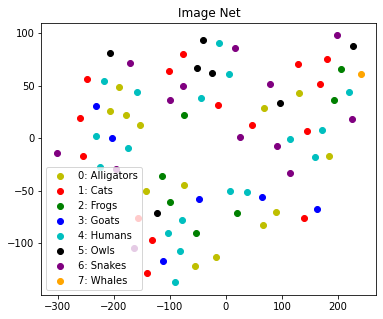

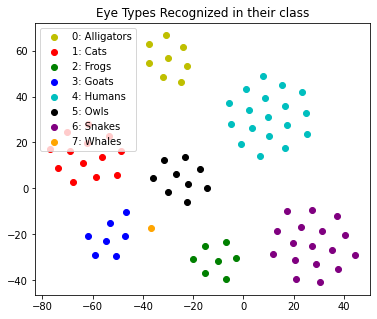

In [17]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=1)

imageNet_X_2d = tsne.fit_transform(imageNet_feats)
eyeTypes_X_2d = tsne.fit_transform(eye_feats)

plt.figure(figsize=(6, 5))
for i in range(imageNet_X_2d.shape[0]):
  if labels[i] == 0:
    class0 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='y')

  if labels[i] == 1:
    class1 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='r')

  if labels[i] == 2:
    class2 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='g')

  if labels[i] == 3:
    class3 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='b')

  if labels[i] == 4:
    class4 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='c')

  if labels[i] == 5:
    class5 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='k')

  if labels[i] == 6:
    class6 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='purple')

  if labels[i] == 7:
    class7 = plt.scatter(imageNet_X_2d[i,0], imageNet_X_2d[i, 1], c='orange')

plt.title('Image Net')
plt.legend((class0, class1, class2, class3, class4, class5, class6, class7), ('0: Alligators', '1: Cats', '2: Frogs', '3: Goats', '4: Humans', '5: Owls', '6: Snakes', '7: Whales'))

plt.figure(figsize=(6, 5))
for i in range(eyeTypes_X_2d.shape[0]):
  if lables[i] == 0:
    class0 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='y')
  
  if lables[i] == 1:
    class1 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='r')
  
  if lables[i] == 2:
    class2 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='g')
  
  if lables[i] == 3:
    class3 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='b')
  
  if lables[i] == 4:
    class4 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='c')
  
  if lables[i] == 5:
    class5 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='k')
  
  if lables[i] == 6:
    class6 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='purple')
  
  if lables[i] == 7:
    class7 = plt.scatter(eyeTypes_X_2d[i,0], eyeTypes_X_2d[i, 1], c='orange')

plt.title('Eye Types Recognized in their class')
plt.legend((class0, class1, class2, class3, class4, class5, class6, class7), ('0: Alligators', '1: Cats', '2: Frogs', '3: Goats', '4: Humans', '5: Owls', '6: Snakes', '7: Whales'))
plt.show()